# Tile masking
Masking is a common operation to use when performing analysis across tiles. Tile masking allows one to compare two tiles, a value tile and a masking tile. The masking tile can be thought of as being placed on top of the other tile, obscuring certain values. Masking cells set to NODATA are opaque, and cells that are anything else are transparent. In this way, value cells that correspond to masking cells that are NODATA become NODATA and value cells corresponding to other values are untouched.

Initial setup:

In [192]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession
from pathlib import Path
import numpy as np

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
sc = spark.sparkContext

resource_dir = Path('./samples').resolve()

def readTiff(name):
    return resource_dir.joinpath(filenamePattern.format(name)).as_uri()

filenamePattern = "L8-B{}-Elkton-VA.tiff"
bandNumbers = range(1, 5)
bandColNames = list(map(lambda n: 'band_{}'.format(n), bandNumbers))

In [205]:
# The literal column will be used to perform a join later
from functools import reduce
joinedRF = reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2.drop('bounds').drop('metadata')),
                  map(lambda bf: spark.read.geotiff(bf[1]) \
                      .withColumnRenamed('tile', 'band_{}'.format(bf[0])),
                  map(lambda b: (b, readTiff(b)), bandNumbers))).withColumn("joinCol", lit(1)).asRF()

In [194]:
joinedRF.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|spatial_key|              bounds|            metadata|              band_1|              band_2|              band_3|              band_4|joinCol|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|      [0,0]|POLYGON ((703986....|Map(AREA_OR_POINT...|geotrellis.raster...|geotrellis.raster...|geotrellis.raster...|geotrellis.raster...|      1|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+



In [195]:
rastArray = joinedRF.toDoubleRaster("band_1", 186, 169)

+--------------------------+
|celltypeexpression(band_1)|
+--------------------------+
|                 uint16raw|
+--------------------------+



We take the values from our raster array and run them through a threshold, returning one if they are high enough and NaN if they are too low.

In [196]:
threshold = []
for i in range(0, 31434):
    if rastArray[i] > 10500:
        threshold.append(1.0)
    else:
        threshold.append(np.NaN)

In [197]:
df = sc.parallelize([list([threshold])]).toDF()

In [223]:
from pyspark.sql.functions import lit
tiledDF = df.withColumn("maskTile", arrayToTile("_1", 186, 169)).withColumn("joinCol", lit(1))

The cell type here is initially raw, which means that it does not support any NODATA value, which is a requirement for masking. We use `convertCellType` to change the type away from raw.

In [264]:
joinedRF.select(cellType("band_2")).show()

joinedRF = joinedRF.withColumn("band_2_ND", convertCellType("band_2", 'uint16'))

joinedRF.select(cellType("band_2_ND")).show()

+--------------------------+
|celltypeexpression(band_2)|
+--------------------------+
|                 uint16raw|
+--------------------------+

+-----------------------------+
|celltypeexpression(band_2_ND)|
+-----------------------------+
|                       uint16|
+-----------------------------+



In [226]:
joinedRF.printSchema()

root
 |-- spatial_key: struct (nullable = false)
 |    |-- col: integer (nullable = false)
 |    |-- row: integer (nullable = false)
 |-- bounds: polygon (nullable = true)
 |-- metadata: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = false)
 |-- band_1: rf_tile (nullable = false)
 |-- band_2: rf_tile (nullable = false)
 |-- band_3: rf_tile (nullable = false)
 |-- band_4: rf_tile (nullable = false)
 |-- joinCol: integer (nullable = false)
 |-- band_2_ND: rf_tile (nullable = true)



Because the tile has a cellType of raw, there is not a NODATA value. One possible solution is to convert the CellType to something that does support NODATA values. This transformation is wrapped into a threshold function that creates a new tile based on whether the cell values in an input tile are higher than a certain number.

First, must create a masking tile based on some criteria, in this case, whether a cell value is past a threshold. This tile is full of either NODATA cells or the unchanged cell values corresponsing to whether the value in the input cell is greater than a threshold.

In [227]:
withMaskedTile = joinedRF.join(tiledDF, joinedRF["joinCol"] == tiledDF["joinCol"], how="outer")

In [237]:
withMaskedTile = withMaskedTile.withColumn("maskTileND", convertCellType("maskTile", 'uint16'))

In [238]:
withMaskedTile.select(noDataCells("maskTileND")).show()

+-----------------------+
|noDataCells(maskTileND)|
+-----------------------+
|                  28570|
+-----------------------+



## Mask 
Mask is an operation that takes two tiles and eliminates data from one cell that corresponds to a value in the other. For instance, if a cell in the masking tile contains a NODATA, the corresponding cell in the other tile would be set to NODATA. If the masking cell contained anything else, the corresponding cell would have its value untouched. The mean is thus high, since all cells with a low reflectance were masked over.

In [262]:
masked = withMaskedTile \
  .withColumn("masked", mask(joinedRF["band_2_ND"], withMaskedTile["maskTileND"])).asRF()
masked.select(tileStats("masked")).show(truncate=False)

+-------------------------------------------------------------+
|tileStats(masked)                                            |
+-------------------------------------------------------------+
|[2864,-1,9630.0,22147.0,10648.890363128503,1494703.325270259]|
+-------------------------------------------------------------+



### Inverse Mask
Inverse mask works in the opposite way; It doesn't touch the cells that are set to NODATA in the masking tile and all other cells become NODATA. The mean is low for the same reason that the masked mean is high: High values were reverse masked over.

In [263]:
inversemasked = withMaskedTile \
  .withColumn("inversemasked", inverseMask(joinedRF["band_2_ND"], withMaskedTile["maskTileND"])).asRF()
inversemasked.select(tileStats("inversemasked")).show(truncate=False)

+------------------------------------------------------------+
|tileStats(inversemasked)                                    |
+------------------------------------------------------------+
|[28570,-1,8275.0,9996.0,8756.359047952406,118202.5029361604]|
+------------------------------------------------------------+



In [ ]:
raster1 = np.asarray(list(masked.toIntRaster('masked', 186, 169)))
pixels1 = np.reshape(raster1, (169, 186))
raster2 = np.asarray(list(inversemasked.toIntRaster('inversemasked', 186, 169)))
pixels2 = np.reshape(raster2, (169, 186))

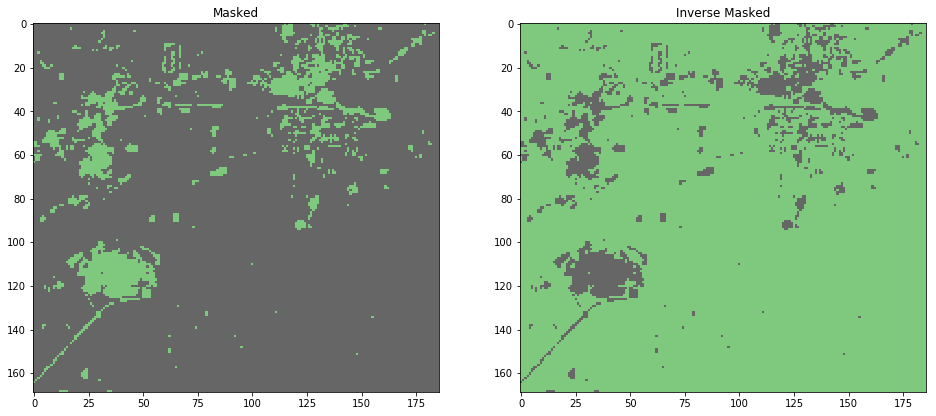

In [259]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(16,16))
fig.add_subplot(1, 2, 1).set_title("Masked")
imgplot = plt.imshow(pixels1)
imgplot.set_cmap('Accent_r')
fig.add_subplot(1, 2, 2).set_title("Inverse Masked")
imgplot = plt.imshow(pixels2)
imgplot.set_cmap('Accent_r')